In [15]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import pandas as pd
import unsupervised_scripts

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2750)): ').strip() or '2750')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(input('Enter HSI step size: ').strip()) 
ch_start = int(input('Enter stack index for 2800 cm^-1 (Default="auto"): ').strip() or str(int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')
shift = 15

## Training Directory (different for everyone)
path_dir = 'D:/Shi_Lab/Spectral_Clustering/'
data_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
sample_dir = data_dir + 'training_data/'

artificial_dataset = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df, shift)
artificial_dataset.save_artificial_dataset(molecule_df,sample_dir, noise_param=0.75)


100%|██████████| 26/26 [00:00<00:00, 9382.42it/s]


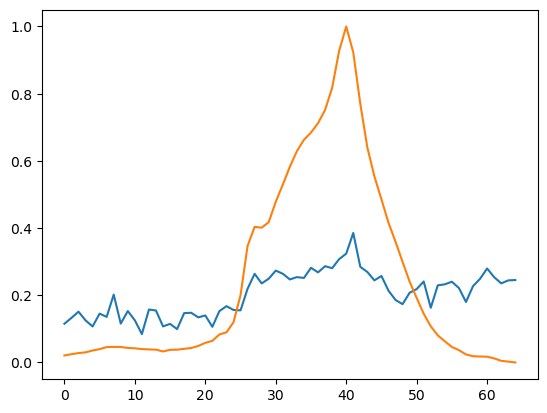

In [13]:
import matplotlib.pyplot as plt
X_data = np.load('artificial_training_data-'+str(num_samp)+'.npy')
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
[mol_norm, _] =  artificial_dataset.molecule_dataset(molecule_df)

plt.plot(X[141])
plt.plot(mol_norm[1])

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import os
from skimage import io
from scipy.interpolate import CubicSpline
from tqdm import tqdm
import helper_scripts

# Sample Directory (different for everyone)
path_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
data_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/'
sample_dir = data_dir +'training_data/'

sample_list = os.listdir(sample_dir)

# Index of 2800 cm-1
cs_end = 17

# Convert image spectra to vectors and remove outliers
count = 0
for name in tqdm(sample_list):
    image = io.imread(sample_dir + name)
    image_vector = np.reshape(image, (image.shape[0], image.shape[1] * image.shape[2]))
    first_val = np.mean(image_vector[-1:-10:-1, :])
    image_vector = image_vector - first_val.T
    image_vector = np.flip(image_vector, axis=0)
    if count > 0:
        temp = np.concatenate((temp, image_vector), axis=1)
    else:
        temp = image_vector
    count += 1
image_spec = helper_scripts.normalize(temp)
image_spec = image_spec[:, np.logical_not(image_spec[0, :] > image_spec[-1, :])]
image_vec = image_spec[:, np.all(
    np.logical_and(image_spec[:cs_end] < np.mean(image_spec[:cs_end]) + 3 * np.std(image_spec[:cs_end]),
                   image_spec[:cs_end] > np.mean(image_spec[:cs_end]) - 3 * np.std(image_spec[:cs_end])), axis=0)]

# Identify number of HSI slices and HSI wavenumber boundaries
num_samp = 65
wavenum_1 = 2685
wavenum_2 = 3085

# Use image vectors to inform artificial training data
standard_dev = np.std(image_vec[:cs_end, :], axis=0)
start_vec = image_vec[0]
scale_vec = image_vec[-1] - image_vec[0]
max_vec = np.max(image_vec, axis=0)
ratio_scale_vec = max_vec-start_vec
noise_scale_vec = standard_dev

# Load and interpolate molecule spectra
lipid_subtype_df = pd.read_excel('lipid_subtype.xlsx')
lipid_subtype_df = lipid_subtype_df.dropna(axis='columns',how='all')
lip_df_size = lipid_subtype_df.columns.shape[0]
lipid_subtype_arr = lipid_subtype_df.to_numpy()
lip_size = int(lip_df_size / 2)
temp_lipid_names = np.array(lipid_subtype_df.columns[0:lip_df_size:2])
wavenumber = np.linspace(wavenum_1, wavenum_2, num_samp)
temp_lipids = np.empty((lip_size, num_samp), dtype='float32')
remove_nan = []
for i in list(range(0, lip_df_size, 2)):
    lipx = lipid_subtype_arr[:, i]
    lipy = lipid_subtype_arr[:, i + 1]
    lipx = lipx[~np.isnan(lipx)]
    lipy = lipy[~np.isnan(lipy)]
    if lipx.min() <= wavenum_1 and lipx.max() >= wavenum_2:
        temp_spline = CubicSpline(lipx, lipy, extrapolate=True)
        temp_lipids[int(i / 2)] = temp_spline(wavenumber)
    else:
        remove_nan.append(int(i / 2))
keep_lip = [i for i in range(temp_lipids.shape[0]) if i not in remove_nan]
lipids = temp_lipids[keep_lip, :]
lip_norm = helper_scripts.lip_normalize(lipids)
lip_norm = np.vstack((lip_norm, np.zeros(lip_norm.shape[1],dtype='float32')))
lip_names = temp_lipid_names[keep_lip]
lip_names = np.hstack((lip_names, 'Background'))
lip_norm = helper_scripts.lip_normalize(lipids)

# Load and interpolate PBS spectra
pbs_1 = wavenum_1
pbs_2 = wavenum_2
CH_length = num_samp  # Keep like this for images measuring 2700-3100 cm^-1
CH_wavenumber = np.linspace(pbs_1,pbs_2,CH_length)
PBS_CSV = pd.read_csv('water_HSI_76.csv')
PBS = PBS_CSV[8:].to_numpy() 
PBS = PBS[:,0]
pbsx = np.linspace(pbs_1, pbs_2,len(PBS))
pbsy = list(PBS)
pbs_spline = CubicSpline(pbsx, pbsy)
pbs = np.zeros(num_samp)
if num_samp != CH_length:
    pbs[0:CH_length] = pbs_spline(CH_wavenumber)
else:
    pbs = pbs_spline(CH_wavenumber)
pbs = helper_scripts.normalize(pbs)

# Add a background class
molecule_norm = np.vstack((lip_norm, np.zeros(num_samp, dtype='float32')))
mol_names = np.hstack((lip_names, 'Background'))

# Generate artificial molecular spectra from spontaneous spectra
mol_norm = molecule_norm

# Generate artificial SRS spectra from the molecular spectra
num_values = 500
random_integers = np.random.randint(0, int(scale_vec.shape[0]), size=num_values)
pbs_scale = scale_vec[random_integers]
ch_scale = ratio_scale_vec[random_integers]
noise_scale = 0.5*noise_scale_vec[random_integers]
background = np.flip(np.outer(pbs_scale, pbs),axis=1)
noise = np.random.normal(0, noise_scale, (num_samp, num_values)).T
artificial_mol = np.zeros((mol_norm.shape[0], num_values, mol_norm.shape[1]), dtype='float32')
artificial_labels = np.zeros(artificial_mol.shape, dtype='float32')
for mol_index in tqdm(range(len(mol_norm))):
    mol_temp = mol_norm[mol_index]
    mol_vec = np.outer(ch_scale, mol_temp)
    artificial_mol[mol_index] = (mol_vec + noise + background)
    artificial_labels[mol_index] = mol_vec
artificial_mol= helper_scripts.normalize(artificial_mol)
artificial_labels = helper_scripts.normalize(artificial_labels)

artificial_labels = np.tile(artificial_labels, (10, 1, 1, 1))
artificial_mol = np.tile(artificial_mol, (10, 1, 1, 1))
#artificial_labels = np.moveaxis(artificial_labels, 2, 1)
artificial_mol = np.moveaxis(artificial_mol, 2, 1)
#artificial_labels = np.reshape(artificial_labels,(artificial_labels.shape[0] * artificial_labels.shape[1], artificial_labels.shape[2], artificial_labels.shape[3]))
artificial_mol = np.reshape(artificial_mol, (artificial_mol.shape[0] * artificial_mol.shape[1], artificial_mol.shape[2], artificial_mol.shape[3]))
artificial_mol = np.flip(artificial_mol,axis=2)

100%|██████████| 26/26 [00:00<00:00, 2943.53it/s]


In [107]:
np.save('artificial_training_data-28.npy', artificial_mol)
np.save('artificial_training_labels-28.npy', artificial_labels)